In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os, gc
import sys

sys.path.append(r"../")
from data_loader import Preprocessed_data_loader
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

from catboost import CatBoostRegressor

from datetime import datetime

In [11]:
IS_CUSTOM = True
USE_VALID = True
show=True
use = [
    'KnowledgeTag',
    'KnowledgeTag_answerCode_median',
    'KnowledgeTag_answerCode_sum',
    'KnowledgeTag_answerCode_var',
    'assessmentItemID_answerCode_median',
    'assessmentItemID_elo_pred',
    'dayofweek_answerCode_count',
    'dayofweek_answerCode_var',
    'elapsedTime',
    'feature_ensemble_elo_pred',
    'hour',
    'hour_answerCode_count',
    'mid3',
    'testId_elapsedTime_median',
    'testId_elo_pred',
    'userID_answerCode_median',
    'userID_answerCode_sum',
    'userID_first3_answerCode_count',
    'userID_first3_answerCode_mean',
    'userID_first3_answerCode_var',
    'user_acc',
    'user_correct_answer',
    'user_total_answer'
 ]+['answerCode']
data = Preprocessed_data_loader(path="../../data", IS_CUSTOM=IS_CUSTOM)
train = data.train_df[use]
_test = data.test_df[use]
test = _test[_test.answerCode==-1]
valid = _test[_test.answerCode!=-1]

x_train = train.drop("answerCode",axis=1)
y_train = train.answerCode

x_valid = valid.drop("answerCode",axis=1)
y_valid = valid.answerCode

x_test = test.drop("answerCode",axis=1)
y_test = test.answerCode

cat_features = [i for i in data.cat_features if i in use]
# if n_components:
#     x_train, x_valid, y_train, y_valid, test = xgb_PCA_data_loader(IS_CUSTOM=IS_CUSTOM,USE_VALID=USE_VALID,DROPS=DROPS, n_components=n_components, valid_len=valid_len)
# else:
#     x_train, x_valid, y_train, y_valid, test = xgb_data_loader(IS_CUSTOM=IS_CUSTOM,USE_VALID=USE_VALID,DROPS=DROPS, valid_len=valid_len)

# CatBoostRegressor

In [17]:
best_param = {#0.8529083201761338
    'iterations': [1309], 
    'od_wait': [1156], 
    'learning_rate': 0.12050525980538551, 
    'reg_lambda': 33.60940884741316, 
    'subsample': 0.8788606724227271, 
    'random_strength': 15.025636973633025, 
    'depth': 8, 
    'min_data_in_leaf': 15, 
    'leaf_estimation_iterations': 7, 
    'bagging_temperature': 0.17557926195300713, 
    'colsample_bylevel': 0.7321063114295764}
model = CatBoostRegressor(cat_features=cat_features, logging_level="Silent", eval_metric='AUC', **best_param)
# , logging_level="Silent","Info"
if USE_VALID:
    model = CatBoostRegressor(cat_features=cat_features, use_best_model=True, logging_level="Silent", eval_metric='AUC', **best_param)

predict = None
param_grid = {
        'iterations': [200],
        'depth': [10],
        'learning_rate': [0.1],
        # 'custom_loss': ['TotalF1'],
        # 'eval_metric': ['TotalF1'],
        # 'random_seed': [42],
        # 'min_data_in_leaf': [5],
        # 'max_leaves': [200],
        # 'l2_leaf_reg': [100],
        # 'border_count': [100],
        # 'bagging_temperature': [500],
}
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
cv = KFold(n_splits=6, random_state=42, shuffle=True)

gcv = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=1,
    pre_dispatch=8,
    # verbose=1,
)

In [18]:
torch.cuda.empty_cache()
gc.collect()

3238

In [19]:

if USE_VALID:
    model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)],plot=show, verbose=show)
else:
    model.fit(x_train, y_train,plot=show, verbose=show)
# , verbose=2, silent=False
# print("final params", gcv.best_params_)
# print("best score", gcv.best_score_)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [20]:
# SAVE OUTPUT
# model = gcv.best_estimator_
sub = pd.read_csv("/opt/ml/input/data/sample_submission.csv")
sub["prediction"] = model.predict(x_test)

output_dir = "./output/"
now = datetime.now()
now_str = "{:%Y-%m-%d_%H:%M:%S}".format(now)
file_name = f"CTB_R_grid_kfold_custom_submission_{now_str}.csv"
write_path = os.path.join(output_dir, file_name)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, "w", encoding="utf8") as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(sub["prediction"]):
        w.write("{},{}\n".format(id, p))

writing prediction : ./output/CTB_R_grid_kfold_custom_submission_2022-12-07_06:47:17.csv


In [21]:
def get_accuracy(PRED_PATH=file_name):
    threshold = 0.5
    ANSWER_PATH = "../../data/custom_answer.csv"

    submission_result = pd.read_csv(PRED_PATH)
    answer = pd.read_csv(ANSWER_PATH)

    y_pred, y = submission_result["prediction"], answer["prediction"]

    return f"accuracy_score: {accuracy_score(y,y_pred.apply(lambda x: 1 if x > threshold else 0))}\nroc  auc_score: {roc_auc_score(y,y_pred)}"

In [22]:
if IS_CUSTOM:
    print(get_accuracy("output/" + file_name))


accuracy_score: 0.7661290322580645
roc  auc_score: 0.8352413626621216


In [30]:
best_model = CatBoostRegressor(cat_features=cat_features, logging_level="Silent", eval_metric='AUC', **best_param)

best_model.fit(pd.concat([x_train,x_valid]),pd.concat([y_train,y_valid]), plot=True, verbose=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [31]:
# SAVE OUTPUT
# model = gcv.best_estimator_
sub = pd.read_csv("/opt/ml/input/data/sample_submission.csv")
sub["prediction"] = best_model.predict(x_test)

output_dir = "./output/"
now = datetime.now()
now_str = "{:%Y-%m-%d_%H:%M:%S}".format(now)
file_name = f"NoValid_CTB_R_custom_submission_{now_str}.csv"
write_path = os.path.join(output_dir, file_name)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, "w", encoding="utf8") as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(sub["prediction"]):
        w.write("{},{}\n".format(id, p))

writing prediction : ./output/NoValid_CTB_R_custom_submission_2022-12-07_07:11:32.csv


In [32]:
print(get_accuracy("output/" + file_name))

accuracy_score: 0.7634408602150538
roc  auc_score: 0.8380357417174458


In [34]:
_sub = pd.read_csv("../../data/preprocessed_test_data.csv")[use]
submission = _sub[_sub.answerCode==-1].drop("answerCode",axis=1)
submission

,KnowledgeTag,KnowledgeTag_answerCode_median,KnowledgeTag_answerCode_sum,KnowledgeTag_answerCode_var,assessmentItemID_answerCode_median,assessmentItemID_elo_pred,dayofweek_answerCode_count,dayofweek_answerCode_var,elapsedTime,feature_ensemble_elo_pred,...,testId_elapsedTime_median,testId_elo_pred,userID_answerCode_median,userID_answerCode_sum,userID_first3_answerCode_count,userID_first3_answerCode_mean,userID_first3_answerCode_var,user_acc,user_correct_answer,user_total_answer
1035,469,0.452495,-0.593362,0.910494,0.575070,-0.787989,-0.530240,-1.295598,0.009950,-0.504555,...,0.976374,-0.229461,0.442500,1.046258,2.387549,0.001913,0.817223,0.176433,2.457569,2.541501
1706,781,0.452495,-0.857710,0.927782,0.575070,-0.363159,-2.555482,-1.156223,-0.459141,-0.207928,...,0.976374,0.182250,0.442500,0.131436,0.463232,0.225733,0.503098,0.183380,1.219910,1.241496
3023,820,-2.213085,-0.802039,0.986940,-1.754784,-1.889980,-2.555482,-1.156223,-0.765071,-1.858561,...,-1.302231,-1.788353,0.442500,1.765047,0.745701,-1.219492,1.038004,0.190232,3.430016,3.542328
4283,309,-2.213085,-1.503967,0.843229,-1.754784,-1.105216,0.158683,0.634079,0.601414,-0.833695,...,-0.877581,-0.230006,0.442500,2.186156,0.405856,1.247066,-2.006363,0.863119,3.999732,3.339313
4670,183,0.452495,0.077445,0.714107,-1.754784,-1.248851,0.158683,0.634079,-0.581513,-0.552925,...,0.319160,0.457663,0.442500,-0.492966,0.061597,0.750841,-0.567455,0.537405,0.375158,0.229984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260052,883,0.452495,-0.808245,0.048616,-1.754784,-2.187570,0.888516,-0.680169,-0.887442,-1.742117,...,0.164742,-0.923024,-2.267771,-1.531216,-1.372814,-2.263869,-0.947981,-1.937817,-1.029487,-1.062898
260067,589,0.452495,0.738910,-1.449986,0.575070,0.297522,0.888516,-0.680169,1.254063,0.218516,...,-0.221304,0.163414,-0.493524,-1.531216,-1.394881,-0.572526,1.338260,-0.872803,-1.029487,-1.094953
260082,865,0.452495,-0.008122,-1.439191,0.575070,0.366125,-2.555482,-1.156223,-0.438746,0.259126,...,-0.452931,0.012545,-0.493524,-1.531216,-1.399295,0.041749,0.750332,-0.872803,-1.029487,-1.094953
260097,865,0.452495,-0.008122,-1.439191,0.575070,-0.414090,-2.555482,-1.156223,-0.499932,-0.667232,...,-0.452931,-0.934242,-2.267771,-1.549368,-1.399295,0.041749,0.750332,-2.816876,-1.054044,-1.094953


In [36]:
sample_submission = pd.read_csv("../../data/sample_submission.csv")
sample_submission.prediction = best_model.predict(submission)
sample_submission

,id,prediction
0,0,0.542294
1,1,0.652721
2,2,0.236788
3,3,0.851336
4,4,0.264294
...,...,...
739,739,0.002552
740,740,0.692632
741,741,0.765253
742,742,0.816730


In [38]:
sample_submission.to_csv("CatBoostRegressor_1207.csv",index=False)

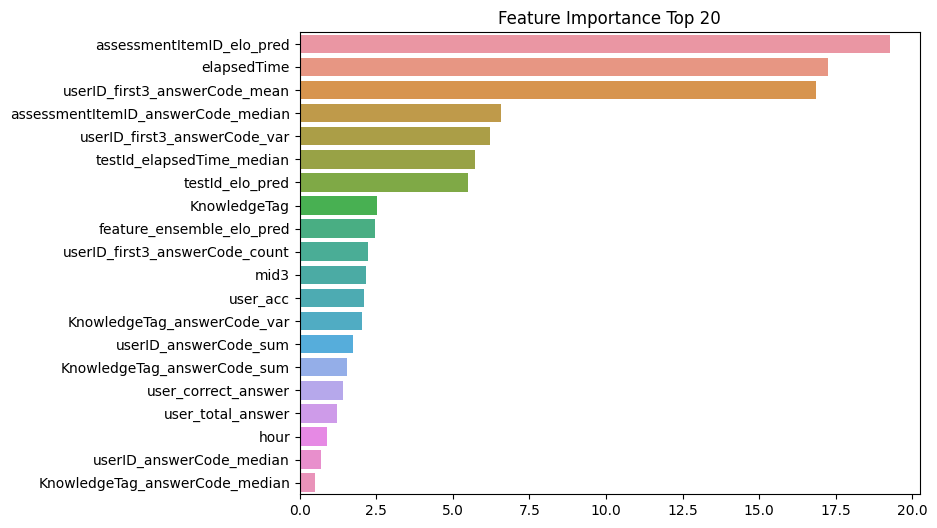

In [23]:
ft_importance_values = model.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
ft_series = pd.Series(ft_importance_values, index = x_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

In [24]:
x_train.columns

Index(['KnowledgeTag', 'KnowledgeTag_answerCode_median',
       'KnowledgeTag_answerCode_sum', 'KnowledgeTag_answerCode_var',
       'assessmentItemID_answerCode_median', 'assessmentItemID_elo_pred',
       'dayofweek_answerCode_count', 'dayofweek_answerCode_var', 'elapsedTime',
       'feature_ensemble_elo_pred', 'hour', 'hour_answerCode_count', 'mid3',
       'testId_elapsedTime_median', 'testId_elo_pred',
       'userID_answerCode_median', 'userID_answerCode_sum',
       'userID_first3_answerCode_count', 'userID_first3_answerCode_mean',
       'userID_first3_answerCode_var', 'user_acc', 'user_correct_answer',
       'user_total_answer'],
      dtype='object')

<AxesSubplot: >

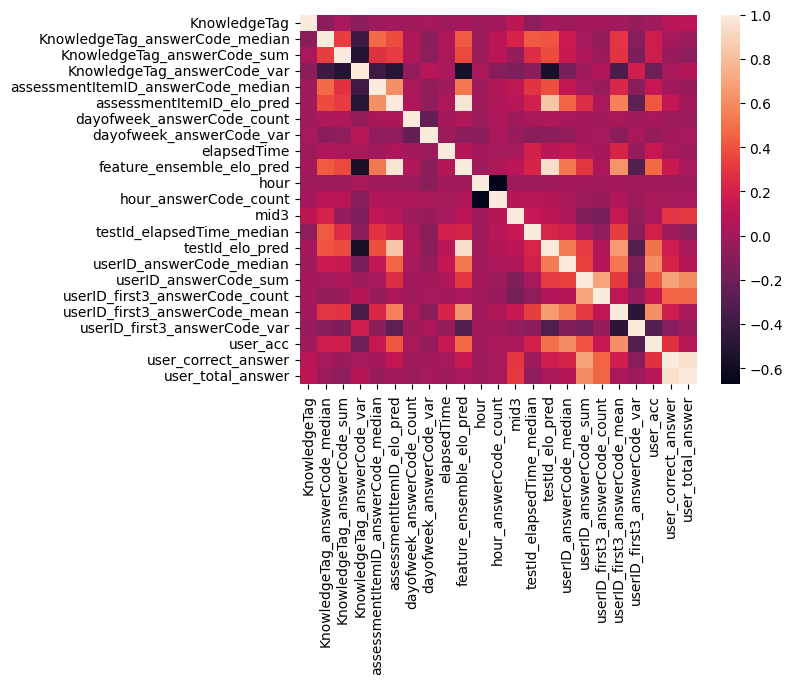

In [25]:
sns.heatmap(x_train.corr())

# Optuna

In [14]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [ ]:
answer = pd.read_csv()

In [ ]:
"""
{#0.8529083201761338
    'iterations': 1309, 
    'od_wait': 1156, 
    'learning_rate': 0.12050525980538551, 
    'reg_lambda': 33.60940884741316, 
    'subsample': 0.8788606724227271, 
    'random_strength': 15.025636973633025, 
    'depth': 8, 
    'min_data_in_leaf': 15, 
    'leaf_estimation_iterations': 7, 
    'bagging_temperature': 0.17557926195300713, 
    'colsample_bylevel': 0.7321063114295764}. Best is trial 12 with value: 0.8529083201761338.

"""

In [38]:
# random sampler
sampler = TPESampler(seed=10)
"""
{'iterations': 1225, 'od_wait': 1137, 'learning_rate': 0.13961885418362568, 'reg_lambda': 99.70281020294294, 'subsample': 0.9865639083871036, 'random_strength': 20.91136981025462, 'depth': 8, 'min_data_in_leaf': 6, 'leaf_estimation_iterations': 5, 'bagging_temperature': 0.06743840501796786, 'colsample_bylevel': 0.6721574718318712}
"""
# define function
def objective(trial):

    cbrm_param = {
        'iterations':trial.suggest_int("iterations", 1300, 1500),
        'od_wait':trial.suggest_int('od_wait', 1000, 1500),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.1, 0.2),
        'reg_lambda': trial.suggest_uniform('reg_lambda',10,50),
        'subsample': trial.suggest_uniform('subsample',0.6,1),
        'random_strength': trial.suggest_uniform('random_strength',10,20),
        'depth': trial.suggest_int('depth',6, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',10,20),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',5,8),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.1, 3.00),
        'colsample_bylevel':trial.suggest_float('colsample_bylevel', 0.7, 0.9),
    }

    # Generate model
    model_cbrm = CatBoostRegressor(**cbrm_param)
    model_cbrm = model_cbrm.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], 
                           verbose=0, early_stopping_rounds=25)
                           
	# 평가지표 원하는 평가 지표가 있을 시 바꾸어 준다.
    auc = roc_auc_score(y_valid, model_cbrm.predict(x_valid))
    return auc

optuna_cbrm = optuna.create_study(direction='maximize', sampler=sampler)
optuna_cbrm.optimize(objective, n_trials=50)

[I 2022-12-07 05:49:03,869] A new study created in memory with name: no-name-b6cfd9f5-c0e6-4126-b79e-ca09a5c98246
[W 2022-12-07 05:51:37,822] Trial 0 failed because of the following error: KeyboardInterrupt('')
Traceback (most recent call last):
  File "/opt/conda/envs/ctb/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_104090/570832951.py", line 25, in objective
    model_cbrm = model_cbrm.fit(x_train, y_train, eval_set=[(x_valid, y_valid)],
  File "/opt/conda/envs/ctb/lib/python3.10/site-packages/catboost/core.py", line 5730, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/envs/ctb/lib/python3.10/site-packages/catboost/core.py", line 2355, in _fit
    self._train(
  File "/opt/conda/envs/ctb/lib/python3.10/site-packages/catboost/core.py", line 1759, in _train
    self._object._train(train

KeyboardInterrupt: 

In [ ]:
cbrm_trial = optuna_cbrm.best_trial
cbrm_trial_params = cbrm_trial.params
print('Best Trial: score {},\nparams {}'.format(cbrm_trial.value, cbrm_trial_params))

Best Trial: score 0.8526374132586028,
params {'iterations': 1225, 'od_wait': 1137, 'learning_rate': 0.13961885418362568, 'reg_lambda': 99.70281020294294, 'subsample': 0.9865639083871036, 'random_strength': 20.91136981025462, 'depth': 8, 'min_data_in_leaf': 6, 'leaf_estimation_iterations': 5, 'bagging_temperature': 0.06743840501796786, 'colsample_bylevel': 0.6721574718318712}


In [ ]:
cbrm_trial_params

{'iterations': 1225,
 'od_wait': 1137,
 'learning_rate': 0.13961885418362568,
 'reg_lambda': 99.70281020294294,
 'subsample': 0.9865639083871036,
 'random_strength': 20.91136981025462,
 'depth': 8,
 'min_data_in_leaf': 6,
 'leaf_estimation_iterations': 5,
 'bagging_temperature': 0.06743840501796786,
 'colsample_bylevel': 0.6721574718318712}

In [ ]:
submission = data.y_test

AttributeError: 'Preprocessed_data_loader' object has no attribute 'y_test'

In [ ]:
# Modeling fit
cbrm = CatBoostRegressor(**cbrm_trial_params)
cbrm_study = cbrm.fit(x_train, y_train)

# Predict the y_test
submission['prediction'] = cbrm_study.predict(x_test)

In [ ]:
submission